In [1]:
import numpy as np
from matplotlib import pyplot as plt

## ポテンシャルの定義


In [2]:
PERIOD = 2
xs = np.arange(0, PERIOD * 3, PERIOD * 1E-3)

def flat_potential(x):
    return np.zeros_like(x)
    
def ratchet_potential(x, slope1=1., slope2=-0.1, period=PERIOD):
    intersection = - slope2 * period / (slope1 - slope2)
    x_reduced = x % period
    return np.where(x_reduced < intersection, slope1, slope2) * x_reduced + np.where(x_reduced < intersection, 0, (slope1 - slope2) * intersection)

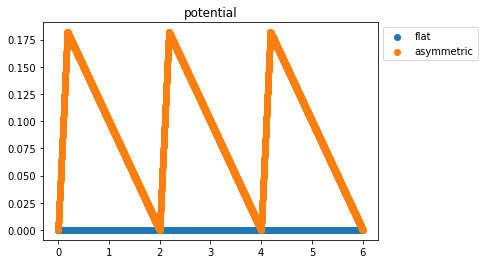

In [3]:
plt.scatter(xs, flat_potential(xs), label="flat")
plt.scatter(xs, ratchet_potential(xs), label="asymmetric")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("potential")
plt.show()

In [4]:
def differential(f, dx=1E-5):
    return lambda x: (f(x + dx) - f(x - dx)) / (2 * dx)

In [5]:
derivative_flat_potential = differential(flat_potential, dx=PERIOD * 1E-3)
derivative_ratchet_potential = differential(ratchet_potential, dx=PERIOD * 1E-3)

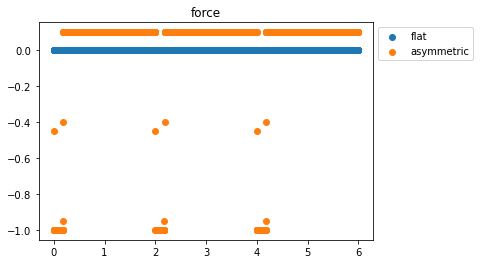

In [6]:
plt.scatter(xs, - derivative_flat_potential(xs), label="flat")
plt.scatter(xs, - derivative_ratchet_potential(xs), label="asymmetric")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("force")
plt.show()

## シュミレーションパラメータの設定

In [7]:
TEMPARATURE = 1E-1  # 温度
VISCOSITY_COEFFICIENT = 1.  # 粘性係数
DELTA_T = 0.1  # 1 stepのシミュレーションで進む時間

NUM_ITERATION = 100000  # 何ステップシミュレーションするか
NUM_ITERATION_FLAT = 10000  # 何ステップ間フラットなポテンシャルにするか
NUM_ITERATION_RATCHET = 10000  # 何ステップ間ラチェットポテンシャルにするか

np.random.seed(39)

## ブラウンラチェットモデルのシミュレーションの実装部分

In [8]:
def simulate_brownian_ratchet(temparature, 
                    viscosity_coefficient, 
                    delta_t,
                    num_iteration,
                    num_iteration_flat,
                    num_iteration_ratchet,
                    boltzmann_constant=1.):
    """
    ブラウンラチェットモデルのシミュレーションを計算

    Parameters
    ----------
    temparature : float
        温度
    viscosity_coefficient : float
        粘性係数
    delta_t : float
        1 ステップのシミュレーションで進む時間
    num_iteration : int
        何ステップシミュレーションするか
    num_iteration_flat : int
        何ステップ間フラットなポテンシャルにするか
    num_iteration_ratchet : int
        何ステップ間ラチェットポテンシャルにするか
    boltzmann_constant : float
        ボルツマン定数 (デフォルトでは1. に設定)

    Returns
    -------
    x_trajectory : list of float
        各ステップにおける粒子の座標をならべたリスト
    """
    
    x_trajectory = [0]
    for i in range(num_iteration):
        if i % (num_iteration_flat + num_iteration_ratchet) < num_iteration_flat:
            derivative = derivative_flat_potential
        else:
            derivative = derivative_ratchet_potential

        x_next = (x_trajectory[i] 
                    + np.sqrt(2 * boltzmann_constant * temparature / viscosity_coefficient * delta_t) * np.random.randn()
                    - derivative(x_trajectory[i]) / viscosity_coefficient * delta_t)
        x_trajectory.append(x_next)
    return x_trajectory

In [9]:
x_trajectory_brownian_ratchet = simulate_brownian_ratchet(TEMPARATURE,
                                                        VISCOSITY_COEFFICIENT,
                                                        DELTA_T,
                                                        NUM_ITERATION,
                                                        NUM_ITERATION_FLAT,
                                                        NUM_ITERATION_RATCHET,
                                                        )
"""
比較のためにポテンシャルが常にフラットな場合 (すなわちただのブラウン運動) も計算
"""
x_trajectory_brownian = simulate_brownian_ratchet(TEMPARATURE,
                                                        VISCOSITY_COEFFICIENT,
                                                        DELTA_T,
                                                        NUM_ITERATION,
                                                        NUM_ITERATION_FLAT,
                                                        0,
                                                        )

## 結果

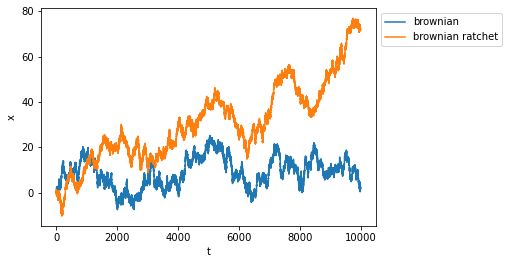

In [10]:
ts = np.linspace(0, (len(x_trajectory_brownian) - 1) * DELTA_T, len(x_trajectory_brownian))
plt.plot(ts, x_trajectory_brownian, label="brownian")
plt.plot(ts, x_trajectory_brownian_ratchet, label="brownian ratchet")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("t")
plt.ylabel("x")
plt.show()

ブラウンラチェットモデルでは正の方向に粒子が流れていくが、
ブラウン運動では初期位置の周辺で止まっている

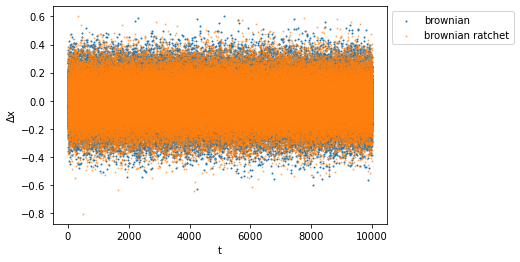

average of Δx
brownian : 2.356643191776028e-05
brownian ratchet : 0.0007209730224804056


In [11]:
plt.scatter(ts[:-1], np.diff(x_trajectory_brownian, 1), label="brownian", s=1)
plt.scatter(ts[:-1], np.diff(x_trajectory_brownian_ratchet, 1), alpha=0.5, label="brownian ratchet", s=1)
plt.xlabel("t")
plt.ylabel("Δx")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
print(f"average of Δx")
print(f"brownian : {np.average(np.diff(x_trajectory_brownian, 1))}")
print(f"brownian ratchet : {np.average(np.diff(x_trajectory_brownian_ratchet, 1))}")